In [1]:
import tensorflow as tf
from __future__ import division, print_function, absolute_import
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

C:\Users\ragja\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ragja\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ragja\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ragja\Anaconda3\envs\test\lib\site-packages\tensorflow\python\frame

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
fmnist = input_data.read_data_sets('data/fashion', source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion\train-labels-idx1-ubyte.gz
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Extracting data/fashion\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [11]:
np.random.seed(134) 
tf.set_random_seed(34)

In [12]:
num_steps=100000 #No of times generator/discriminator is updated before it moves onto discriminator/generator?
learning_rate=0.0002
batch_size=128 #So that you don't have to load all your data at once

#Network Parameters
image_dim=784
gen_hnode_dim=1000
dis_hnode_dim=1000
noise_dim=100

#Initializing the weight parameters:
# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

drop_out_rate=tf.placeholder(tf.float32)
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

In [13]:
#Defining in a way to avoid extra code

weights={'gen_ilayer':tf.Variable(glorot_init([noise_dim,gen_hnode_dim])),
         'gen_olayer':tf.Variable(glorot_init([gen_hnode_dim,image_dim])),
         'dis_ilayer':tf.Variable(glorot_init([image_dim,dis_hnode_dim])),
         'dis_olayer':tf.Variable(glorot_init([dis_hnode_dim,1]))}
biases={'gen_ilayer':tf.Variable(tf.zeros([gen_hnode_dim])),
         'gen_olayer':tf.Variable(tf.zeros([image_dim])),
         'dis_ilayer':tf.Variable(tf.zeros([dis_hnode_dim])),
         'dis_olayer':tf.Variable(tf.zeros([1]))}

In [14]:
def generator(data,dropout_rate):       
    l1=tf.add(tf.matmul(data,weights['gen_ilayer']),biases['gen_ilayer'])
    l1=tf.nn.relu(l1)    
    l1 = tf.layers.dropout(l1, dropout_rate)
    output=tf.add(tf.matmul(l1,weights['gen_olayer']),biases['gen_olayer'])
    output = tf.nn.tanh(output)
    return output
    

In [15]:
def discriminator(data,dropout_rate,seed):
    l1=tf.add(tf.matmul(data,weights['dis_ilayer']),biases['dis_ilayer'])
    l1=tf.nn.relu(l1)
    l1 = tf.layers.dropout(l1, dropout_rate,seed=seed)
    output=tf.add(tf.matmul(l1,weights['dis_olayer']),biases['dis_olayer'])
    output = tf.nn.sigmoid(output)
    return output

In [16]:
gen_sample=generator(gen_input,drop_out_rate)
seed=np.random.randint(5,1000)
disc_real=discriminator(disc_input,drop_out_rate,seed)
disc_fake=discriminator(gen_sample,drop_out_rate,seed)

beta=0.01
regularizers_gen = tf.nn.l2_loss(weights['gen_olayer']) + tf.nn.l2_loss(weights['gen_ilayer'])
regularizers_dis = tf.nn.l2_loss(weights['dis_olayer']) + tf.nn.l2_loss(weights['dis_ilayer'])

# Build Loss
gen_loss = -tf.reduce_mean(tf.log(disc_fake))
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))

#Add L2/Weight Decay regularization
gen_loss = tf.reduce_mean(gen_loss + beta * regularizers_gen)
disc_loss = tf.reduce_mean(disc_loss + beta * regularizers_dis)

#Building optimizer for generator and discriminator
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

generator_var=[weights['gen_ilayer'],weights['gen_olayer'],
               biases['gen_ilayer'],biases['gen_olayer']]

discriminator_var=[weights['dis_ilayer'],weights['dis_olayer'],
               biases['dis_ilayer'],biases['dis_olayer']]
train_gen=optimizer_gen.minimize(gen_loss,var_list=generator_var)
train_dis=optimizer_disc.minimize(disc_loss,var_list=discriminator_var)
#extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
init = tf.global_variables_initializer()
       

In [17]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

Step 0: Generator Loss: 18.469648, Discriminator Loss: 12.273376


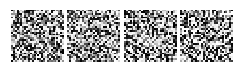

Step 1: Generator Loss: 18.272129, Discriminator Loss: 12.248942


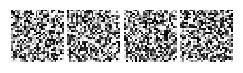

Step 4000: Generator Loss: 4.639680, Discriminator Loss: 0.465738


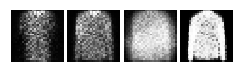

Step 8000: Generator Loss: 3.902834, Discriminator Loss: 0.693469


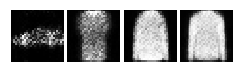

Step 12000: Generator Loss: 4.067841, Discriminator Loss: 0.688049


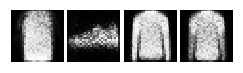

Step 16000: Generator Loss: 4.763079, Discriminator Loss: 0.582089


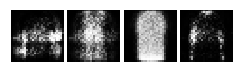

Step 20000: Generator Loss: 4.482591, Discriminator Loss: 0.754234


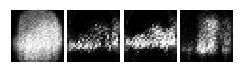

Step 24000: Generator Loss: 3.709573, Discriminator Loss: 0.708822


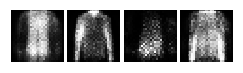

Step 28000: Generator Loss: 3.992562, Discriminator Loss: 0.774857


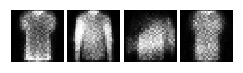

Step 32000: Generator Loss: 4.107276, Discriminator Loss: 0.723376


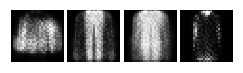

Step 36000: Generator Loss: 3.811192, Discriminator Loss: 0.742968


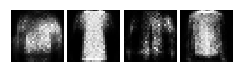

Step 40000: Generator Loss: 3.867747, Discriminator Loss: 0.643395


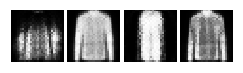

Step 44000: Generator Loss: 3.733522, Discriminator Loss: 0.802214


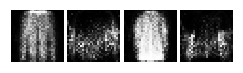

Step 48000: Generator Loss: 3.609761, Discriminator Loss: 0.898234


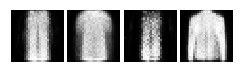

Step 52000: Generator Loss: 3.506725, Discriminator Loss: 0.792620


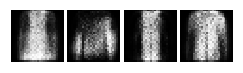

Step 56000: Generator Loss: 3.553415, Discriminator Loss: 0.724482


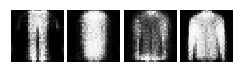

Step 60000: Generator Loss: 3.849716, Discriminator Loss: 0.747325


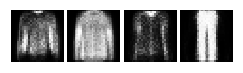

Step 64000: Generator Loss: 3.757913, Discriminator Loss: 0.817037


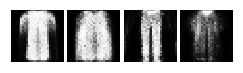

Step 68000: Generator Loss: 3.606680, Discriminator Loss: 0.918905


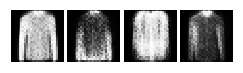

Step 72000: Generator Loss: 3.798099, Discriminator Loss: 1.009625


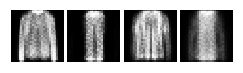

Step 76000: Generator Loss: 3.936153, Discriminator Loss: 0.777395


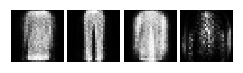

Step 80000: Generator Loss: 4.140037, Discriminator Loss: 0.769765


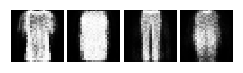

Step 84000: Generator Loss: 3.286351, Discriminator Loss: 0.775321


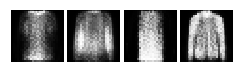

Step 88000: Generator Loss: 4.149648, Discriminator Loss: 0.697103


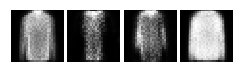

Step 92000: Generator Loss: 3.176177, Discriminator Loss: 0.853752


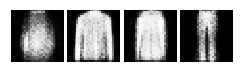

Step 96000: Generator Loss: 3.441840, Discriminator Loss: 0.905560


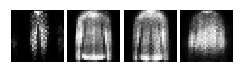

In [18]:
config = tf.ConfigProto(device_count = {'GPU': 1})
sess = tf.Session(config=config)

#with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
sess.run(init)
for i in range(num_steps):
    batch_x, _ = fmnist.train.next_batch(batch_size)
    batch_x = batch_x * 2. - 1.
    z = np.random.normal(0., 1., size=[batch_size, noise_dim])
    _, gl = sess.run([train_gen, gen_loss], feed_dict={gen_input:z, drop_out_rate:0.9})
    _, dl = sess.run([train_dis, disc_loss], feed_dict={disc_input: batch_x, gen_input:z, drop_out_rate:0.9})
    
    if i % 4000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
        z=np.random.normal(0., 1., size=[4, noise_dim])
        samples = sess.run(gen_sample, feed_dict={gen_input: z,drop_out_rate:0.9})
        fig = plot(samples)
        plt.show()

<Figure size 648x648 with 0 Axes>

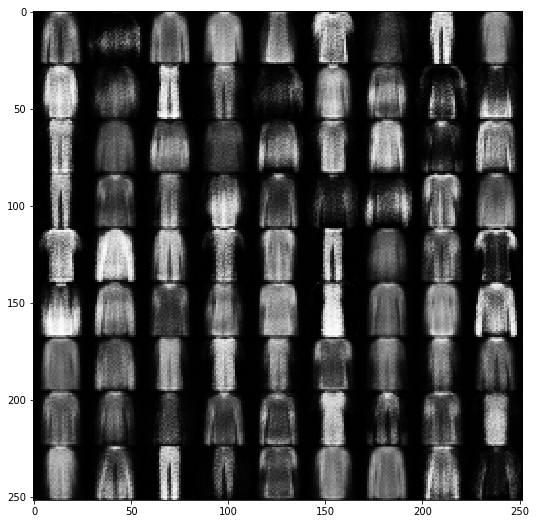

In [21]:
n = 9
averaging_over=5
arr=[]
canvas = np.empty((28 * n, 28 * n))
canvas1 = np.empty((averaging_over,28 * n, 28 * n))

for i in range(n):
    arr=[]
    z = np.random.normal(0., 1., size=[n, noise_dim])
    g = sess.run(gen_sample, feed_dict={gen_input: z,drop_out_rate:0.9})
    g = (g + 1.) / 2.
    for j in range(averaging_over):
        f = sess.run(gen_sample, feed_dict={gen_input: z,drop_out_rate:0.9})
        f = (f + 1.) / 2.
        arr.append(f)
        g+= f
    g=g/11
    for j in range(n):
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28]) 

    for k in range(averaging_over):
        a=arr[k]
        for j in range(n):
            canvas1[k,i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = a[j].reshape([28, 28])    
            
plt.figure(figsize=(n, n))
plt.imshow(canvas1[3], origin="upper", cmap="gray")
plt.imsave('fmnist_mc_dropout_w1.png',canvas,cmap="gray")

for k in range(averaging_over):
    plt.imsave('fmnist_mc_dropout_{}.png'.format(k),canvas1[k],cmap="gray")

plt.show()